<img src="https://cs7.pikabu.ru/post_img/2014/03/10/4/1394427243_1353289544.jpg" height="400" width="400"> 

# <center> ML для маркетинга. <br>  <br> Cюжетная арка 2: отток и привлечение </center>

В этом семестре мы с вами пройдём через несколько сюжетных арок. Второй такой аркой будут отток и привлечение. Им будет посвящена вторая серия из семинаров и домашек. 


#  Часть III (Возвращение менеджера) 

В этой тетрадке мы с вами пытались найти самый классный штраф (коэффициент регуляризации) и пользовались перебором по решётке. А ещё мы немного вспомниил метрики классификации и посравнивали модели между собой. 

In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split

In [2]:
# чтобы нас не раздражали предупреждения, отключим их! 
import warnings
warnings.simplefilter("ignore")

Подгрузим те же самые данные для прогнозирования оттока. 

In [4]:
df_train = pd.read_csv('churn_train.csv', sep='\t')
df_test = pd.read_csv('churn_test.csv', sep='\t')

Разложим их по матрицам. Тренировочную выборку раздробим на тренировочную и валидационную. 

In [5]:
y = df_train['Churn'].astype(int).get_values()
X = df_train.drop('Churn', axis=1).get_values()

y_test = df_test['Churn'].astype(int).get_values()
X_test = df_test.drop('Churn', axis=1).get_values()

Xtr, Xval, ytr, yval = train_test_split(X,y, test_size=0.2,
                                           stratify=y) 

Скопируем логистическую регрессию из старой тетрадки. Посмотрим на её качество. 

In [6]:
# переделаем все в логистическую регрессию! 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(Xtr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [7]:
from sklearn.model_selection import cross_val_score

# Делаем кросс-валидацию (учим 5 моделей и усредняем accuracy)
model = LogisticRegression()
s = cross_val_score(model, X, y, cv=5, scoring='accuracy')
s

array([0.87453184, 0.85365854, 0.85741088, 0.84990619, 0.85928705])

In [8]:
np.mean(s)

0.858958899874219

Тут мы вспомнили, что accuracy плохая метрика, которая очень чувствительна к дисбалансу в выборке. А у нас между прочим на секундочку, $86\%$ нулей. 

In [9]:
# 86% нулей
np.mean(y)

0.1447861965491373

Выходит, что если мы скажем, что каждый из $y$ нулевой, то есть никто не уйдёт от нашего оператора, мы получим accuracy  $0.86$. Проверим это.

In [10]:
from sklearn.metrics import accuracy_score
y_naive = [0]*y_test.size

#а качество получилось таким же 
accuracy_score(y_test, y_naive) 

0.8545727136431784

Выходит, что нам нужна какая-то другая метрика для классификации. Тут мы немного вспомнили про precision, recall. Если забыли что это, [бегом читать прошлогоднюю pdf-ку.](https://github.com/FUlyankin/HSE_Data_Culture/blob/master/Intro_to_DS_2019/sem_7%268_classification/sem7-8_class_solving.pdf)

Мы решили, что хотим смотреть на precision и recall одновременно. Для этого мы придумали $f$-меру, которая одновременно пытается смотреть на важность обеих метрик. Если хочется придумать f-меру самостятельно на примере лайков из уютного vk, можете [посмотреть вот эту неэтичную штуку,](https://nbviewer.jupyter.org/github/FUlyankin/ekanam_grand_research/blob/master/Posts/2.1%20loises_research_post.ipynb) которую я пилил, когда у меня ещё не было работы. 

In [11]:
# старая модель по кросс-валидации 
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
s = cross_val_score(model, X, y, cv=5, scoring='f1')
np.mean(s) # средняя f мера :) 

0.27648499991860714

Какая-то низкая f-мера вышла. Давайте попробуем перебрать по решётке коэффициент регуляризации и посмотрим что будет.

In [12]:
# перебираем лямбду
from sklearn.model_selection import GridSearchCV

params ={'C':np.arange(0.000001,1,0.05)}

model_1 = LogisticRegression()

grid = GridSearchCV(model_1, params, scoring='f1', cv=5)
grid.fit(X, y)

grid.best_score_

0.27983409244881263

In [13]:
grid.best_params_

{'C': 0.750001}

Повысить качество получилось как-то хило. Видимо, линейные моедели не очень хорошо выстреливают на данных про отток. Давайте попробуем перейти к нелинейным моделям, например, случайному лесу. 

In [14]:
from sklearn.ensemble import RandomForestClassifier

# учим лес из 100 деревьев! 
rf = RandomForestClassifier(n_estimators=500)

s = cross_val_score(rf, X, y, cv=5, scoring='f1')
np.mean(s) # средняя f мера :) 

0.7120795795340464

Стало намного лучше! Для случайного леса тоже можно перебрать его разные параметры по `GridSearch`, но это уже домашка. Давайте лучше построим немного прогнозов по нашей модели.

In [15]:
rf.fit(X, y)

p_pred = rf.predict_proba(X_test)[:,-1]
p_pred[:10]

array([0.774, 0.032, 0.158, 0.066, 0.068, 0.026, 0.478, 0.02 , 0.018,
       0.122])

Спрогнозировали для каждого человека вероятность того, что он уйдёт. Теперь давайте посмотрим какими получились $precision, recall$ и матрица ошибок. Понятное дело, что надо зафикисировать какой-то порог, выше которого мы будем считать, что человек уйдёт от нас.

In [21]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix


y_pred = 1*(p_pred > 0.2)
y_pred[:10]

precision_score(y_test, y_pred),recall_score(y_test, y_pred)

(0.7068965517241379, 0.845360824742268)

In [22]:
confusion_matrix(y_test, y_pred)

array([[536,  34],
       [ 15,  82]])

При пороге $0.2$  получается довольно высокая полнота. Точность тоже неплохая. Сколько и каких ошибок мы делаем видно в матрице ошибок. $82$ единицы угадали, $34$ нет. 

Попробуем порог $0.7$.

In [23]:
y_pred = 1*(p_pred > 0.7)
y_pred[:10]

precision_score(y_test, y_pred),recall_score(y_test, y_pred)

(1.0, 0.24742268041237114)

In [24]:
confusion_matrix(y_test, y_pred)

array([[570,   0],
       [ 73,  24]])

Точность зашкаливает, а полнота низкая. $24$ единицы нашли. Ошибок не сделали. При этом $73$ единицы не нашли.

 Интересно, а какие вообще у нас есть комбинации точности и полноты... Построим precision-recall кривую, чтобы посмотреть (в pdf-ке, ссылка на которую есть выше, мы строили эту кривую ручками!)

In [18]:
from sklearn.metrics import precision_recall_curve
pr, rc, ct = precision_recall_curve(y_test, p_pred)

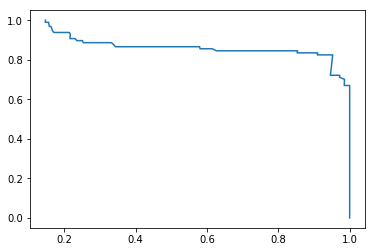

In [20]:
import matplotlib.pyplot as plt
plt.plot(pr, rc)

Кривая показывает какие значения точности и полноты соответствуют каким порогам. В векторе `ct` записаны пороги.

In [33]:
df = pd.DataFrame.from_dict({'precision': pr[1:],'recall' :rc[1:], 'threshold': ct})
df.head()

,precision,recall,threshold
0,0.146565,0.989691,0.006
1,0.148148,0.989691,0.008
2,0.150000,0.989691,0.010
3,0.152139,0.989691,0.012
4,0.155592,0.989691,0.014


Например, если мы хотим чтобы точность была больше $0.8$ и максимальную полноту при этом условии, надо взять порог:

In [42]:
df_pr08 = df[df['precision'] > 0.8]   # отсекли только строчки с точностью больше 0.8
index = df_pr08['recall'].argmax()    # нашли строчку с максимальной полнотой
index

103

In [49]:
df_pr08.loc[index] # посмотрели на эту стрчоку. Порог 0.242, полнота 0.84 и точность 0.81

precision    0.811881
recall       0.845361
threshold    0.242000
Name: 103, dtype: float64

Обычно порог выбирают исходя из бизнес-правила. Например, в данном случае, у нас может быть какая-то сумма денег, которую мы хотим выплатить людям как бонус, чтобы они не уходили из фирмы. Модель поможет найти кому именно платить. В зависимости от того какая у нас есть сумма, мы можем подобрать порог. 